# Mass Transfer (MT) COMSOL Post-Processing
Apr 2nd, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [618]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [619]:
df_123 = pd.read_csv("data/123_data_conc.csv")
df_128 = pd.read_csv("data/128_data_conc.csv")
df_133 = pd.read_csv("data/133_data_conc.csv")
df_140 = pd.read_csv("data/140_data_conc.csv")

df_mass = pd.read_csv("data/mass_data_processed.csv")
df_tc = pd.read_csv("data/tc_data_processed.csv")
df_ane = pd.read_csv("data/anemometer_data_processed.csv")

## Pre-Processing

In [620]:
MW = 18.01528 # g / mol

df_123["c_mass"] = df_123["c"] * MW / 1000
df_128["c_mass"] = df_128["c"] * MW / 1000
df_133["c_mass"] = df_133["c"] * MW / 1000
df_140["c_mass"] = df_140["c"] * MW / 1000

In [621]:
df_ane = df_ane.dropna().reset_index()

In [622]:
df_ane

,index,heater_temp,distance,relative_humidity,air_velocity,temperature_ane
0,0,140,4,25.3,420.0,84.2
1,2,140,12,25.3,322.0,84.2
2,4,140,20,25.3,410.0,84.2
3,5,133,4,27.7,250.0,81.2
4,7,133,12,27.7,190.0,81.2
5,9,133,20,27.7,334.0,81.2
6,10,128,4,30.4,204.0,77.4
7,12,128,12,30.4,227.0,77.4
8,14,128,20,30.4,295.0,77.4
9,15,123,4,33.4,155.0,74.4


In [623]:
df_ane["air_velocity_ms"] = df_ane["air_velocity"] * 0.00508
df_ane["avg_velocity_ms"] = df_ane.groupby("heater_temp")["air_velocity_ms"].transform("mean")

In [624]:
L = 0.555 # m
W = 0.200 # m
area = L * W # m^2

P = 101325 # Pa
P_atm = 1 # atm
D_AB = 2.634 / P # m^2 / s
R = 8.314 # J / mol K

In [625]:
df_mass = df_mass.dropna(subset=["mass_kg"])
df_mass = df_mass.sort_values(by="mass_kg")

In [626]:
def to_C(farenheit):
    return (farenheit - 32) * (5/9)

df_tc["TC1_C"] = df_tc["TC1"].apply(to_C)
df_tc["TC2_C"] = df_tc["TC2"].apply(to_C)
df_tc["TC3_C"] = df_tc["TC3"].apply(to_C)
df_tc["TC4_C"] = df_tc["TC4"].apply(to_C)

In [627]:
def to_K(celsius):
    return celsius + 273.15

df_tc["TC1_K"] = df_tc["TC1_C"].apply(to_K)
df_tc["TC2_K"] = df_tc["TC2_C"].apply(to_K)
df_tc["TC3_K"] = df_tc["TC3_C"].apply(to_K)
df_tc["TC4_K"] = df_tc["TC4_C"].apply(to_K)

## Question 2:
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

For thermal boundary layer, we can use:
$$
\delta_{t} = \frac{T_{bulk} - T_0}{(\frac{dT}{dz})_{z=0}}
$$

This approach will be similar to experimental analysis, however, we will use average temperatures and temperature gradients from simulation results here.

In [ ]:
T_0 = df_123.query("y == 0 and x > 0")["T"]
T_bulk = df_123

In [701]:
delta_T = df_123["T"] - T_0 # same for all heater inputs
print(delta_T)

0       10.627312
1       10.627312
2       10.619667
3       10.626242
4       10.627312
          ...    
4336    -0.350871
4337     0.113713
4338     0.112703
4339    -0.354649
4340    -0.357290
Name: T, Length: 4341, dtype: float64


Now that we have our $\Delta c$ and $\Delta T$, we can compute our concentration and temperature gradients

Text(0.5, 1.0, 'Temperature gradient at interface at 123 C')

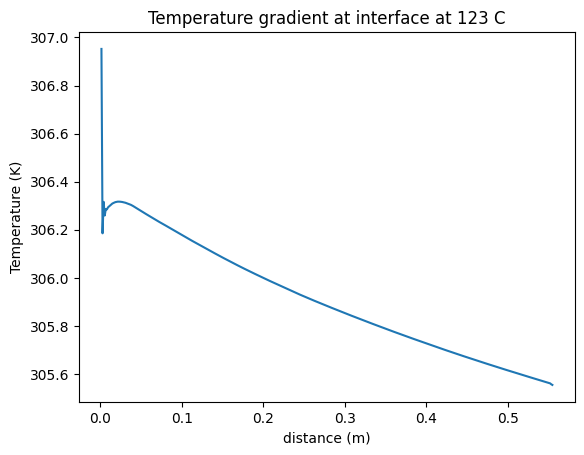

In [702]:
plt.plot(df_123.query("y == 0 and x > 0")["x"], df_123.query("y == 0 and x > 0")["T"])
plt.xlabel("distance (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature gradient at interface at 123 C")

This shows a very non linear trend before 0.05 meters, presumably because this is the length before the pan so it is very turbulent. As the air flow progresses across the pan, the temperature decreases. The question asks to assume linearity, so we will do that for the linear regime of this gradient line. We will classify the regime as linear by inspection. 

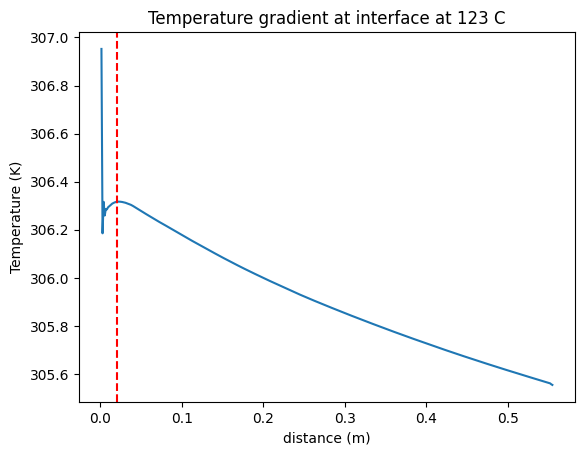

In [703]:
plt.plot(df_123.query("y == 0 and x > 0")["x"], df_123.query("y == 0 and x > 0")["T"])
plt.xlabel("distance (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature gradient at interface at 123 C")
plt.axvline(x=0.02, linestyle="--", color="r")

It seems like the linear regime begins at x = 0.02

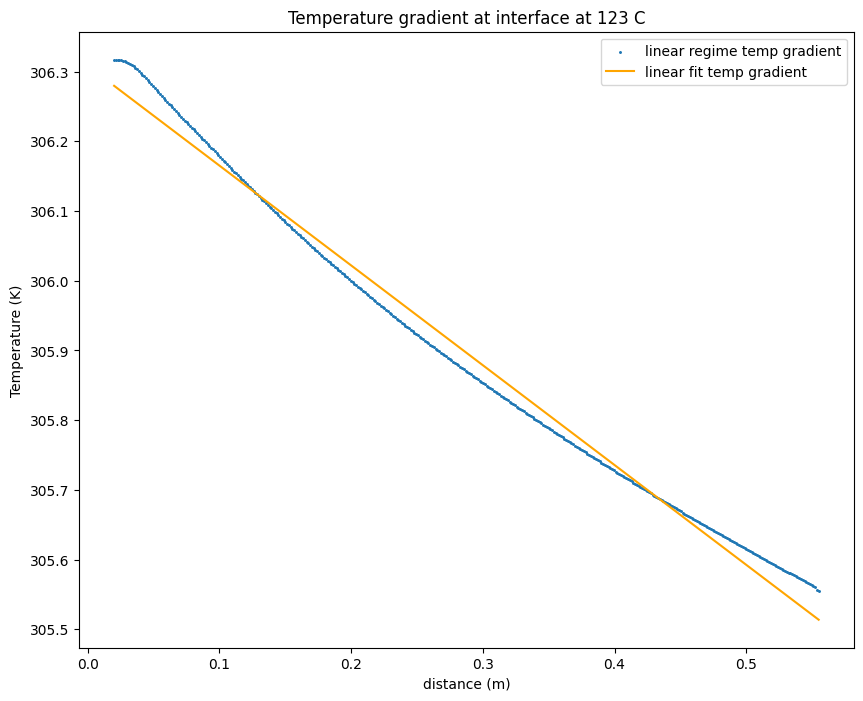

In [704]:
x = df_123.query("y == 0 and x > 0.02")["x"]
T = df_123.query("y == 0 and x > 0.02")["T"]

plt.figure(figsize=(10,8))
plt.xlabel("distance (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature gradient at interface at 123 C")
plt.scatter(x, T, label = "linear regime temp gradient", s=5, marker =".")
slope, intercept, _,_,_ = linregress(x, T)
plt.plot(x, slope*x + intercept, label = "linear fit temp gradient", c = "orange")
plt.legend()

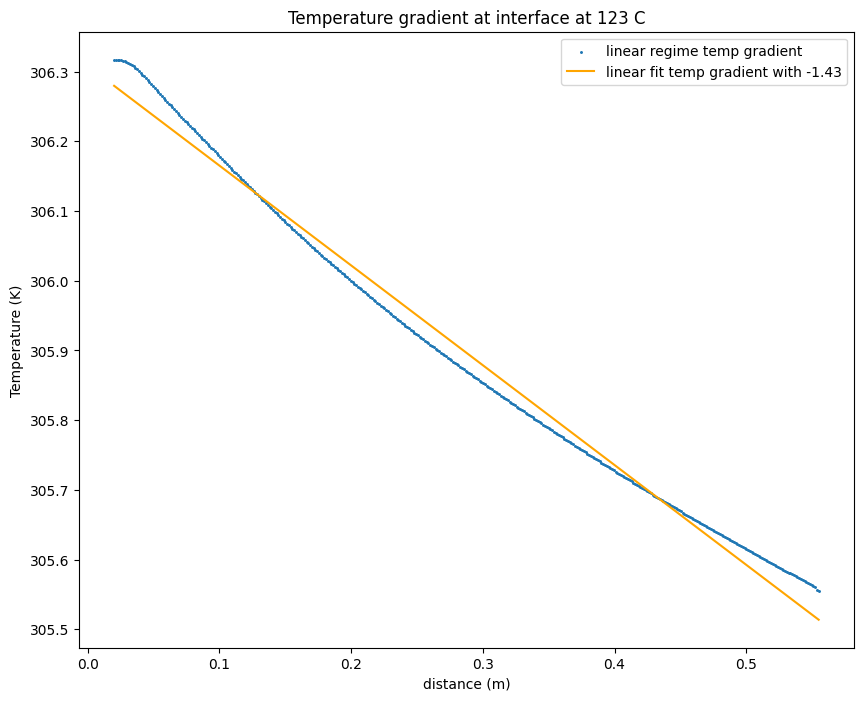

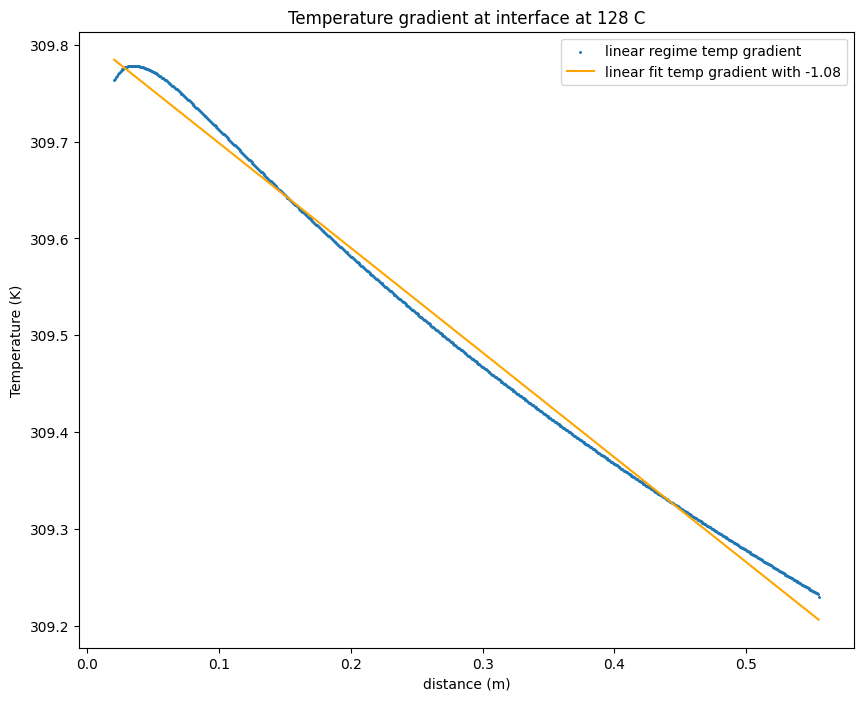

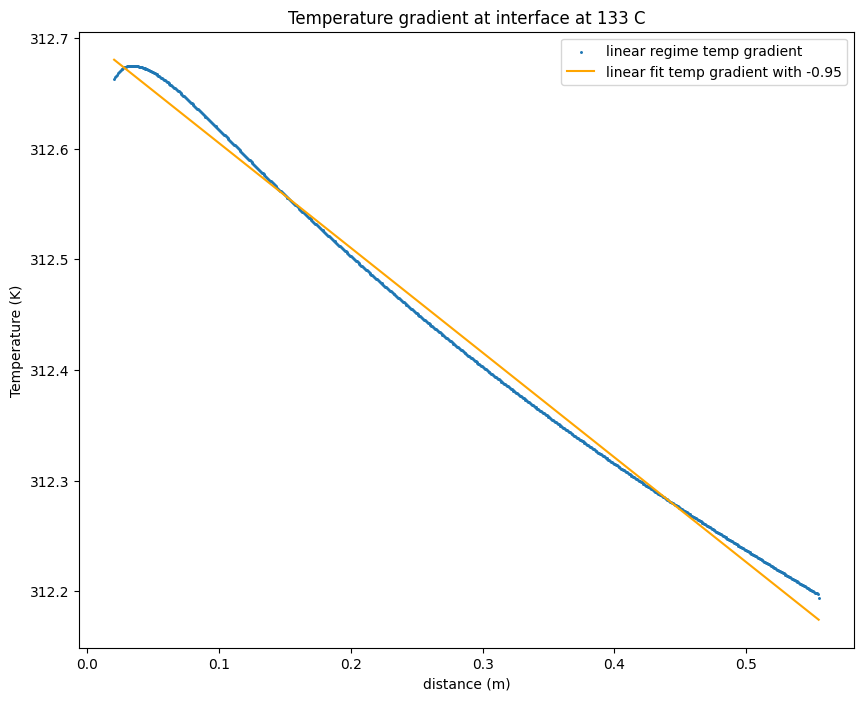

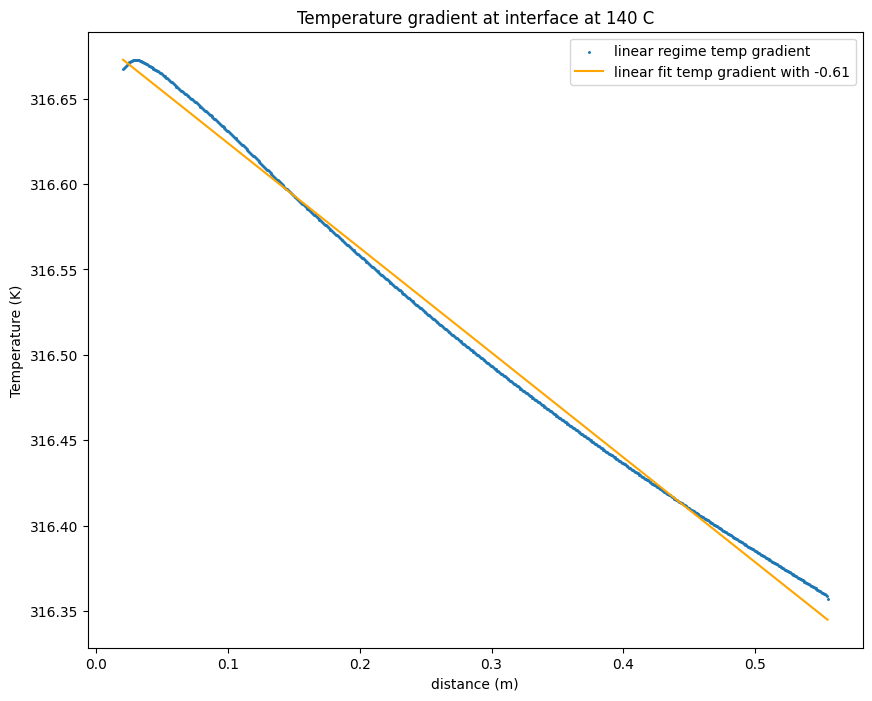

In [705]:
idx_map = {0: 123, 1: 128, 2: 133, 3: 140}
slopes = {}

for i, df in enumerate([df_123, df_128, df_133, df_140]):
    x = df.query("y == 0 and x > 0.02")["x"]
    T = df.query("y == 0 and x > 0.02")["T"]

    plt.figure(figsize=(10,8))
    plt.xlabel("distance (m)")
    plt.ylabel("Temperature (K)")
    plt.title(f"Temperature gradient at interface at {idx_map[i]} C")
    plt.scatter(x, T, label = "linear regime temp gradient", s=5, marker =".")
    slope, intercept, _,_,_ = linregress(x, T)
    slopes[idx_map[i]] = slope
    plt.plot(x, slope*x + intercept, label = f"linear fit temp gradient with {slope:.2f}", c = "orange")
    plt.legend()

Looks like all heater temperature inputs have identical interface tempreature gradients 

In [706]:
df_123["thermal_BL_thickness"] = abs(delta_T / slopes[123])
df_128["thermal_BL_thickness"] = abs(delta_T / slopes[128])
df_133["thermal_BL_thickness"] = abs(delta_T / slopes[133])
df_140["thermal_BL_thickness"] = abs(delta_T / slopes[140])

In [707]:
df_123

,x,y,T,c,c_mass,thermal_BL_thickness
0,0.000000,0.001165,316.538890,0.000000,0.000000,7.422968
1,0.000000,0.000547,316.538890,0.000000,0.000000,7.422968
2,0.000889,0.000946,316.531245,0.000914,0.000016,7.417628
3,0.001411,0.001557,316.537820,0.000152,0.000003,7.422221
4,0.000000,0.002294,316.538890,0.000000,0.000000,7.422968
...,...,...,...,...,...,...
4336,0.552319,0.000000,305.560707,0.361000,0.006504,0.245076
4337,0.553659,0.000261,306.025291,0.350691,0.006318,0.079426
4338,0.555000,0.000261,306.024281,0.350287,0.006311,0.078721
4339,0.553659,0.000000,305.556929,0.361000,0.006504,0.247715


These boundary layer thicknesses are too large to be sensible so we will try a different approach. We will count any concentration above the interface where 90% of the bulk temperature is reached. 

In [637]:
def get_T_BL_thickness(df):
    T_max = df["T"].max()
    return df[df["T"] < 0.99 * T_max]["y"].max()

BL_T_123 = get_T_BL_thickness(df_123)
BL_T_128 = get_T_BL_thickness(df_128)
BL_T_133 = get_T_BL_thickness(df_133)
BL_T_140 = get_T_BL_thickness(df_140)

In [638]:
print(BL_T_123, BL_T_128, BL_T_133, BL_T_140)

0.0051081852855574 0.0042974205808287 0.0037326337187219 0.0024968363565898


We will get concentration by determining the height above the interface where 90% of the bulk concentration is reached

In [639]:
# df_123["x_A0"] = np.exp(18.3036 - (3816.44 / (df_123["T_0"] - 46.13))) / (760 * P_atm)
# df_128["x_A0"] = np.exp(18.3036 - (3816.44 / (df_128["T_0"] - 46.13))) / (760 * P_atm)
# df_133["x_A0"] = np.exp(18.3036 - (3816.44 / (df_133["T_0"] - 46.13))) / (760 * P_atm)
# df_140["x_A0"] = np.exp(18.3036 - (3816.44 / (df_140["T_0"] - 46.13))) / (760 * P_atm)

# df_123["C_bulk"] = P / (R * df_123["T"])
# df_128["C_bulk"] = P / (R * df_128["T"])
# df_133["C_bulk"] = P / (R * df_133["T"])
# df_140["C_bulk"] = P / (R * df_140["T"])

In [640]:
def get_conc_BL_thickness(df):
    c_max = df["c_mass"].max()
    return df[df["c_mass"] > 0.90 * c_max]["y"].max()

BL_c_123 = get_conc_BL_thickness(df_123)
BL_c_128 = get_conc_BL_thickness(df_128)
BL_c_133 = get_conc_BL_thickness(df_133)
BL_c_140 = get_conc_BL_thickness(df_140)

In [641]:
print(BL_c_123, BL_c_128, BL_c_133, BL_c_140)

0.0008593488513211198 0.0007477736016449962 0.0007477736016449962 0.0006439358901197336


## Question 3
Calculate the mass transfer coefficient km as a function of the distance along the water tray
for one of the inlet velocities studied in the experiment. As mentioned in Eq. (4), the ratio
of mass flux to concentration difference driving force defines the mass transfer coefficient.
Explain the trend and what you expect based on theory, and the physical reasoning of such
trends. Here again avoid nonlinear fits and instead linearize your equations so as to enable
use of linear least-squares regression.

From our COMSOL analysis, we have $N_A$ as mass flux to get $k_m$ as:

$$
k_m (x) = \frac{N_A}{c_0- c_{bulk}(x) } 
$$

So our first step is to get $c_0 (x)$

In [642]:
df_123

,x,y,T,c,c_mass
0,0.000000,0.001165,316.538890,0.000000,0.000000
1,0.000000,0.000547,316.538890,0.000000,0.000000
2,0.000889,0.000946,316.531245,0.000914,0.000016
3,0.001411,0.001557,316.537820,0.000152,0.000003
4,0.000000,0.002294,316.538890,0.000000,0.000000
...,...,...,...,...,...
4336,0.552319,0.000000,305.560707,0.361000,0.006504
4337,0.553659,0.000261,306.025291,0.350691,0.006318
4338,0.555000,0.000261,306.024281,0.350287,0.006311
4339,0.553659,0.000000,305.556929,0.361000,0.006504


In [688]:
T_bulk_123 = df_123.query(f"y > @BL_T_123")[["x", "T"]]

In [689]:
N_A_123 = -0.0017986 * MW / 1000 # kg / m^2 s
N_A_128 = -0.0019379 * MW / 1000 # kg / m^2 s
N_A_133 = -0.0020889 * MW / 1000 # kg / m^2 s
N_A_140 = -0.0019698 * MW / 1000 # kg / m^2 s

c_0_123 = df_123.query("y == 0 and x > 0")["c_mass"].mode()

c_bulk_123 = P / R * T_bulk_123["T"]

In [690]:
print(c_bulk_123)

5       3.857738e+06
6       3.857746e+06
7       3.857746e+06
8       3.857742e+06
13      3.857746e+06
            ...     
3481    3.853231e+06
3482    3.855671e+06
3488    3.837131e+06
3489    3.849135e+06
3495    3.828115e+06
Name: T, Length: 1597, dtype: float64


In [691]:
c_0_list = [c_0_123.iloc[0]] * (len(T_bulk_123))

In [692]:
c_bulk_123

5       3.857738e+06
6       3.857746e+06
7       3.857746e+06
8       3.857742e+06
13      3.857746e+06
            ...     
3481    3.853231e+06
3482    3.855671e+06
3488    3.837131e+06
3489    3.849135e+06
3495    3.828115e+06
Name: T, Length: 1597, dtype: float64

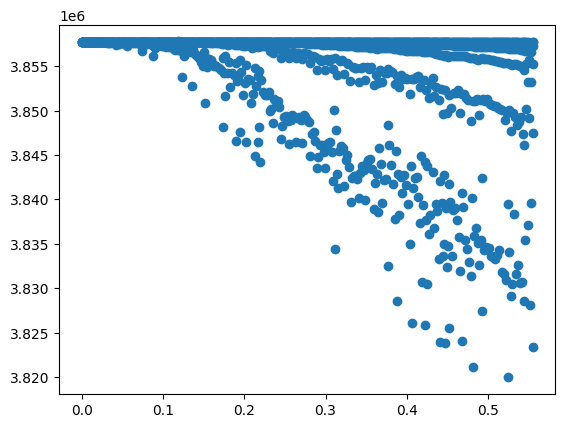

In [693]:
km_123 = N_A_123 / (c_0_list - c_bulk_123)
plt.scatter(T_bulk_123["x"], c_bulk_123)

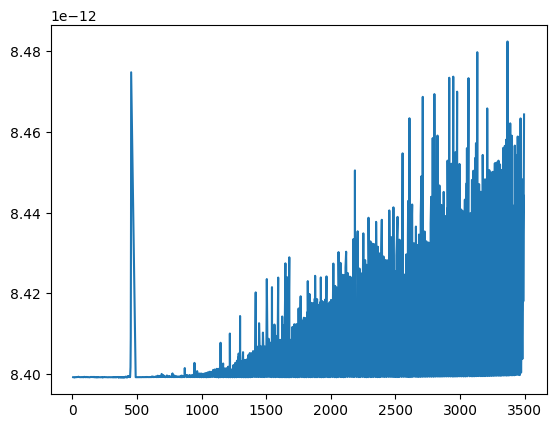

In [649]:
plt.plot(km_123)

## Question 4
Compare the spatially-averaged values of km from the previous part to the values based on
the film theory, i.e., km = D/c. Compare both results with experimental measurements and
explain the cause of differences. Which one do you predict to be higher and why?

## Question 5
Correlate the average value of km as a function of inlet velocity in the form of dimensionless
groups. In particular, Sh = C1*ReC2*ScC3. Specify the characteristic length and transport
properties used for calculating the dimensionless groups. Determine the value of C2 and
compare the result with experiment and with theory. Note that you have not conducted
experiments necessary to determine C1 or C3 independently, so focus only on C2. What
do you conclude about the flow in your system? In a separate plot, plot the average value
of km at a certain inlet velocity with the average boundary-layer thickness at that velocity,
for all velocities. Comment on what is physically driving the scaling of km with velocity.
Here again avoid nonlinear fits and instead linearize your equations so as to enable use of
linear least-squares regression.

## Question 6
Compute the total evaporation rate and compare with the value you found experimentally.
Discuss whether they agree or not and the reasons. Discuss qualitatively the effect of
turbulence on km and boundary-layer thickness.